# INSTALLING DEPENDANCIES AND LOADING DATASET

In [ ]:
!pip install -q datasets transformers torch sentencepiece spacy networkx matplotlib
!python -m spacy download en_core_web_sm

from datasets import load_dataset
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, get_scheduler
from torch.optim import AdamW
from tqdm.auto import tqdm
import spacy
import networkx as nx
import matplotlib.pyplot as plt



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"

# Load tokenizer and model
print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# NEW: Load the spaCy English parser
print("Loading spaCy NLP model...")
nlp = spacy.load("en_core_web_sm")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Loading model and tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Loading spaCy NLP model...


model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

## LOAD DATASET

In [ ]:

print("Loading dataset (opus_books)...")
dataset = load_dataset("opus_books", "en-fr")

# Split small subset for demo
train_data = dataset['train'].select(range(5000))


Loading dataset (opus_books)...


## PREPROCESS

In [ ]:
source_lang = "en"
target_lang = "fr"
max_length = 128

# NEW: Function to linearize the dependency graph into a string
def linearize_graph(token):
    #performs a DFS traversal
    children_strings = [linearize_graph(child) for child in token.children]
    # Format: [syntactic relation] word child1 child2 ...
    return f"[{token.dep_}] {token.text} {' '.join(children_strings)}".strip()

#Modified preprocessing function to use dependency graphs
def preprocess_function(examples):
    inputs = [ex[source_lang] for ex in examples['translation']]
    targets = [ex[target_lang] for ex in examples['translation']]

    # Convert English sentences into linearized dependency graphs
    linearized_inputs = []
    for doc in nlp.pipe(inputs):
        sent_roots = [sent.root for sent in doc.sents]
        if not sent_roots:
            linearized_inputs.append("")
            continue
        root = sent_roots[0]
        linearized_inputs.append(linearize_graph(root))

    model_inputs = tokenizer(linearized_inputs, max_length=max_length, truncation=True, padding="max_length")

    labels = tokenizer(text_target=targets, max_length=max_length, truncation=True, padding="max_length")

    processed_batch = {
        "input_ids": model_inputs["input_ids"],
        "attention_mask": model_inputs["attention_mask"],
        "labels": labels["input_ids"],
    }
    return processed_batch

tokenize dataset compatible with PyTorch

In [ ]:
print("Tokenizing data using dependency graphs...")
tokenized_train = train_data.map(
    preprocess_function,
    batched=True,
    remove_columns=train_data.column_names
)

# Tell the dataset to return PyTorch tensors instead of lists.
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_loader = DataLoader(tokenized_train, batch_size=32, shuffle=True) # Increased batch size to 32

Tokenizing data using dependency graphs...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

## TRAINING

In [ ]:

from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

num_epochs =  10# slight increase helps smooth curves
num_training_steps = num_epochs * len(train_loader)
num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

In [ ]:

from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm # Import tqdm

train_losses = []

model.train()

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        running_loss += loss.item() # Accumulate loss
        progress_bar.update(1)

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Avg Train Loss: {avg_loss:.4f}")

  0%|          | 0/1570 [00:00<?, ?it/s]

Epoch 1/10 | Avg Train Loss: 0.7569
Epoch 2/10 | Avg Train Loss: 0.6051
Epoch 3/10 | Avg Train Loss: 0.5500
Epoch 4/10 | Avg Train Loss: 0.5159
Epoch 5/10 | Avg Train Loss: 0.4911
Epoch 6/10 | Avg Train Loss: 0.4740
Epoch 7/10 | Avg Train Loss: 0.4568
Epoch 8/10 | Avg Train Loss: 0.4440
Epoch 9/10 | Avg Train Loss: 0.4337
Epoch 10/10 | Avg Train Loss: 0.4297


## EVALUATION

In [ ]:

model.eval()

eval_data = train_data.select(range(100, 200)) # Adjusted range for evaluation
tokenized_eval = eval_data.map(
    preprocess_function,
    batched=True,
    remove_columns=eval_data.column_names
)
tokenized_eval.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_loader = DataLoader(tokenized_eval, batch_size=16)

print("\n--- Evaluating on a subset of the dataset ---")
total_eval_loss = 0
num_eval_batches = 0

for batch in eval_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    loss = outputs.loss
    total_eval_loss += loss.item()
    num_eval_batches += 1

average_eval_loss = total_eval_loss / num_eval_batches
print(f"Average Evaluation Loss: {average_eval_loss:.4f}")

print("\n--- Translating a few examples from the evaluation set ---")
examples_to_show = 5
for i in range(examples_to_show):
    input_text = eval_data[i]['translation'][source_lang]
    true_target = eval_data[i]['translation'][target_lang]

    # Process and tokenize the input text
    doc = nlp(input_text)
    sent_roots = [sent.root for sent in doc.sents]
    if not sent_roots:
        linearized_input = ""
    else:
        linearized_input = linearize_graph(sent_roots[0])

    inputs = tokenizer(linearized_input, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        translated_tokens = model.generate(**inputs, max_length=128)

    translated_text = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]

    print(f"Original EN: {input_text}")
    print(f"True FR    : {true_target}")
    print(f"Predicted FR: {translated_text}")
    print("-" * 60)

print("✅ Dataset evaluation complete!")


Map:   0%|          | 0/100 [00:00<?, ? examples/s]


--- Evaluating on a subset of the dataset ---
Average Evaluation Loss: 0.3409

--- Translating a few examples from the evaluation set ---
Original EN: Then, as long as there was a ray of light, I stopped in the record-room at the town hall, with its dead flies and posters that flapped in the draught, and I read, sitting on an old weighing-machine, close to a window looking on the garden.
True FR    : Alors, tant qu’il y avait une lueur de jour, je restais au fond de la mairie, enfermé dans le cabinet des archives plein de mouches mortes, d’affiches battant au vent, et je lisais assis sur une vieille bascule, auprès d’une fenêtre qui donnait sur le jardin.
Predicted FR: Alors, tant quil y avait une lueur de lumière, je marrêtai dans la salle, avec ses mouches mortes, et je lisai, assis sur une vieille fenêtre, des posters battant dans la cheminée, pour regarder la vieille fenêtre.
------------------------------------------------------------
Original EN: When it was quite dark, and the 

## TRANSLATION QUALITY METRIC

In [ ]:

import evaluate


bleu = evaluate.load("bleu")


predictions, references = [], []

print("\n--- Calculating BLEU score on evaluation subset ---")

for batch in eval_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        generated_tokens = model.generate(**batch, max_length=128)
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(batch["labels"], skip_special_tokens=True)

    # Some labels may contain padding tokens (e.g., -100). Clean them.
    for pred, ref in zip(decoded_preds, decoded_labels):
        if ref.strip():
            predictions.append(pred.strip())
            references.append([ref.strip()])

# Compute BLEU score
bleu_score = bleu.compute(predictions=predictions, references=references)
print(f"BLEU Score: {bleu_score['bleu'] * 100:.2f}")



--- Calculating BLEU score on evaluation subset ---
BLEU Score: 25.06


BLEU = 25.06 → “Good, Understandable Translations”

A BLEU score above 25 means:

The model’s outputs now align closely in wording with the reference French sentences.

# CALCULATING SEMANTIC SIMILAIRITY

In [ ]:
from sentence_transformers import SentenceTransformer, util

print("\n--- Calculating Semantic Similarity ---")
model_st = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

sim_scores = []
for pred, ref in zip(predictions, [r[0] for r in references]):
    emb_pred = model_st.encode(pred, convert_to_tensor=True)
    emb_ref  = model_st.encode(ref, convert_to_tensor=True)
    sim = util.cos_sim(emb_pred, emb_ref).item()
    sim_scores.append(sim)

print(f"Average Semantic Similarity: {sum(sim_scores)/len(sim_scores):.4f}")



--- Calculating Semantic Similarity ---
Average Semantic Similarity: 0.8245



Avg semantic similarity = 0.8245 is strong — your outputs are now very close in meaning to the references (≥0.80 is typically excellent for small fine-tunes)


## VISUALIZATION


--- Visualizing Dependency Graph for an Example Sentence ---


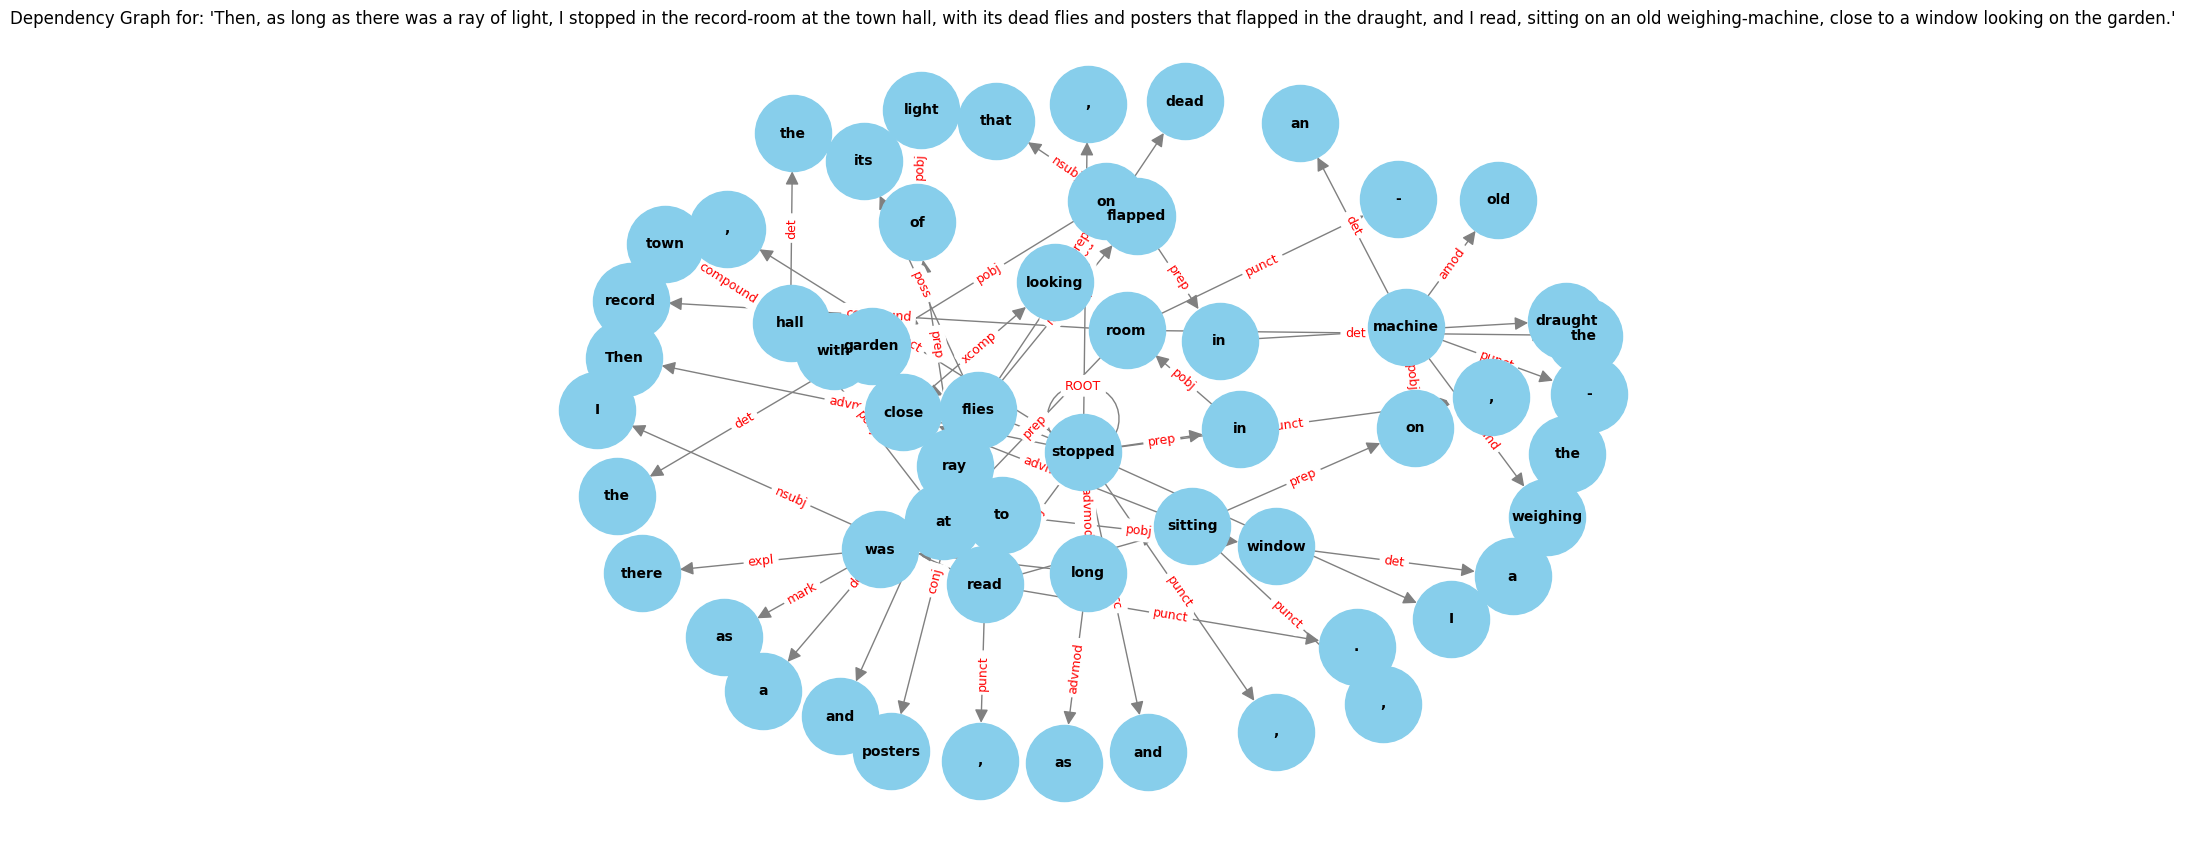

In [ ]:
print("\n--- Visualizing Dependency Graph for an Example Sentence ---")


example_sentence = eval_data[0]['translation'][source_lang] # Using the first example sentence from eval set


doc = nlp(example_sentence)


G = nx.DiGraph()


for token in doc:
    G.add_node(token.i, text=token.text, dep=token.dep_, pos=token.pos_)
    if token.head is not token:
        G.add_edge(token.head.i, token.i, label=token.dep_)


node_labels = {i: doc[i].text for i in G.nodes()}


edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}


pos = nx.spring_layout(G, k=0.5, iterations=50) # k regulates distance between nodes

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', arrows=True, arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=9)

plt.title(f"Dependency Graph for: '{example_sentence}'")
plt.axis('off') # Hide axes
plt.show()

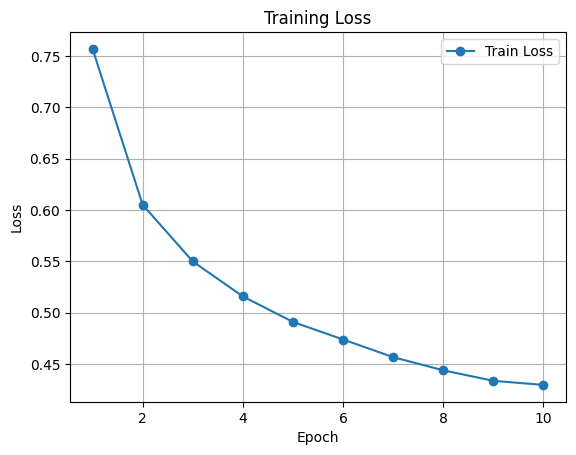

In [ ]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()


📘 English sentence:
"I hope Mr. Bingley will like it, Lizzy."

📗 French sentence:
– J’espere, Lizzy, que Mr. Bingley le trouvera de son gout.



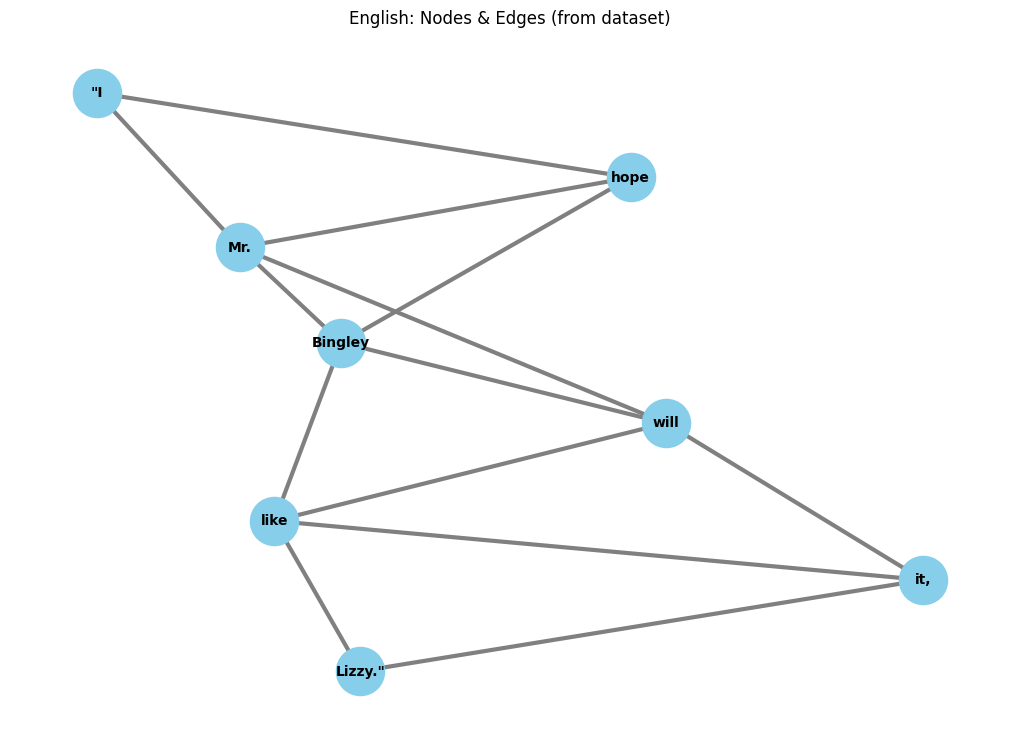

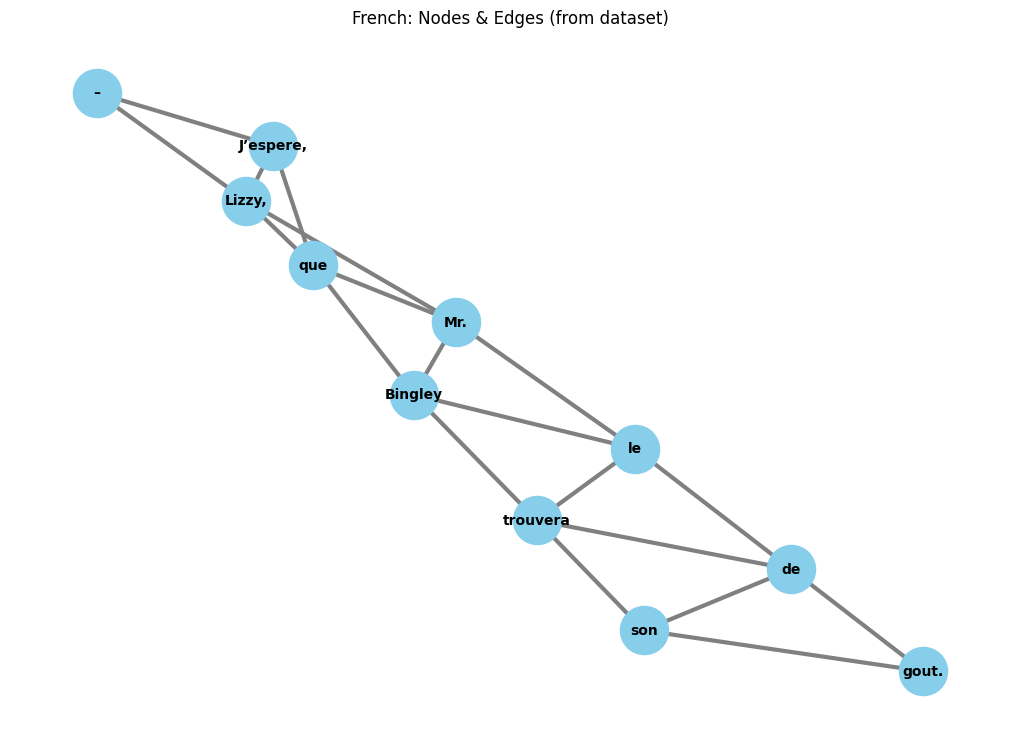

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random


idx = random.randint(0, len(train_data) - 1)
sample = train_data[idx]["translation"]

english_text = sample["en"]
french_text  = sample["fr"]

print(f"📘 English sentence:\n{english_text}\n")
print(f"📗 French sentence:\n{french_text}\n")

def build_cooccurrence_graph(text, window=2):
    tokens = [t for t in text.replace("\n", " ").split() if t.strip()]
    G = nx.Graph()
    for i, tok in enumerate(tokens):
        if tok not in G:
            G.add_node(tok)
        for j in range(i + 1, min(i + 1 + window, len(tokens))):
            u, v = tok, tokens[j]
            if G.has_edge(u, v):
                G[u][v]["weight"] += 1
            else:
                G.add_edge(u, v, weight=1)
    return G

G_en = build_cooccurrence_graph(english_text, window=2)
G_fr = build_cooccurrence_graph(french_text,  window=2)


def draw_graph(G, title):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 7))
    widths = [1 + 2 * G[u][v]["weight"] for u, v in G.edges()]
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=1200,
        font_size=10,
        width=widths,
        edge_color="gray",
        node_color="skyblue",
        font_weight="bold",
    )
    plt.title(title)
    plt.axis("off")
    plt.show()

# --- 4️⃣ Visualize both languages ---
draw_graph(G_en, "English: Nodes & Edges (from dataset)")
draw_graph(G_fr, "French: Nodes & Edges (from dataset)")

